# Fixed array size, variable number of versions

For this test, we have generated `.h5` data files using the `generate_data.py` script from the repository, using the following options:

- `test_large_fraction_changes_sparse`: 
    - `num_rows_initial = 5000`
    - `num_rows_per_append = 10`
    - `pct_inserts = 1`
    - `num_inserts = 10`
    - `pct_deletes = 1`
    - `num_deletes = 10`
    - `pct_changes = 90`
    - `num_changes = 1000`
- `test_small_fraction_changes_sparse`
    - `num_rows_initial = 5000`
    - `num_rows_per_append = 10`
    - `pct_inserts = 1`
    - `num_inserts = 10`
    - `pct_deletes = 1`
    - `num_deletes = 10`
    - `pct_changes = 90`
    - `num_changes = 10`
- `test_mostly_appends_sparse`:
    - `num_rows_initial = 1000`
    - `num_rows_per_append = 1000`
    - `pct_inserts = 5`
    - `num_inserts = 10`
    - `pct_deletes = 1`
    - `num_deletes = 10`
    - `pct_changes = 5`
    - `num_changes = 10`  
- `test_mostly_appends_dense`
    - `num_rows_initial_0 = 30`
    - `num_rows_initial_1 = 30`
    - `num_rows_per_append_0 = 1`
    - `pct_inserts = 5`
    - `num_inserts_0 = 1`
    - `num_inserts_1 = 10`
    - `pct_deletes = 1`
    - `num_deletes_0 = 1`
    - `num_deletes_1 = 1`
    - `pct_changes = 5`
    - `num_changes = 10`

## Setup

The path to the generated test files is

In [7]:
path = "/home/melissa/projects/versioned-hdf5" # change this as necessary

In [8]:
%matplotlib inline
import os
import sys
sys.path.append('..')
import pickle
import numpy as np
import matplotlib.pyplot as plt
import h5py
from versioned_hdf5 import VersionedHDF5File

In [9]:
# auxiliary code to format file sizes 
def format_size(size):
    suffixes = ['B', 'KB', 'MB', 'GB']
    i = 0
    while size >= 1024 and i < len(suffixes)-1:
        size = size/1024
        i += 1
    return f"{size:.2f} {suffixes[i]}"

# Test 1: Large fraction changes (sparse)

In [10]:
testname = "test_large_fraction_changes_sparse"

We have tested the following numbers of versions (or transactions):

In [11]:
num_transactions_1 = [50, 100, 500, 1000, 5000, 7500, 10000, 12000, 15000, 20000, 30000]

In [12]:
tests = []
for t in num_transactions_1:
    filename = os.path.join(path, testname+"_"+str(t)+".h5")
    h5pyfile = h5py.File(filename, 'r')
    data = VersionedHDF5File(h5pyfile)
    tests.append(dict(num_transactions=t, filename=filename, h5pyfile=h5pyfile, data=data))

## Number of versions v. File size

We'll start by analyzing how the `.h5` file sizes grow as the number of versions grows. 

In [13]:
for test in tests:
    test['size'] = os.path.getsize(test['filename'])
    test['size_label'] = format_size(test['size'])

Note that the array size also grows as the number of versions grows, since each transaction is changing the original arrays by adding, deleting and changing values in the original arrays. In order to compute a (naive) theoretical lower bound on the file size, we'll compute how much space each version should take. Keep in mind there is redundant data as some of it is not changed during the staging of a new version but it is still being stored. In this example, we start with three arrays with 5000 elements (2 integer arrays and one float), and in the end we have the following array sizes:

In [ ]:
for test in tests:
    lengths = []
    total_size = 0
    for vname in test['data']._versions:
        if vname != '__first_version__':
            version = test['data'][vname]
            group_key = list(version.keys())[0]
            lengths.append(len(version[group_key]['val']))
            total_size += len(version[group_key]['val'])
    test['theoretical_sizes'] = 24*total_size
    print(f"Maximum array size for file with {test['num_transactions']}: {max(lengths)}")

```
Maximum array size for file with 50: 5500
Maximum array size for file with 100: 6000
Maximum array size for file with 500: 10000
Maximum array size for file with 1000: 15000
Maximum array size for file with 5000: 55000
Maximum array size for file with 7500: 80000
Maximum array size for file with 10000: 105000
Maximum array size for file with 12000: 125000
Maximum array size for file with 15000: 155000
Maximum array size for file with 20000: 205000
Maximum array size for file with 30000: 305000
```

In [ ]:
test_large_fraction_changes_sparse = []
for test in tests:
    test_large_fraction_changes_sparse.append(dict((k, test[k]) for k in ['num_transactions', 'filename', 'size', 'size_label', 'theoretical_sizes']))

Just for the sake of reproducibility, we'll pickle the filesizes for these tests so we can recover them later:

In [11]:
with open("test_large_fraction_changes_sparse_versions.pickle","wb") as pickle_out:
    pickle.dump(test_large_fraction_changes_sparse, pickle_out)

In [15]:
with open("test_large_fraction_changes_sparse_versions.pickle", "rb") as pickle_in:
    test_large_fraction_changes_sparse = pickle.load(pickle_in)

Let's show the size information in a graph:

In [16]:
filesizes_1 = np.array([test['size'] for test in test_large_fraction_changes_sparse])
sizelabels_1 = np.array([test['size_label'] for test in test_large_fraction_changes_sparse])
tsizes_1 = np.array([test['theoretical_sizes'] for test in test_large_fraction_changes_sparse])

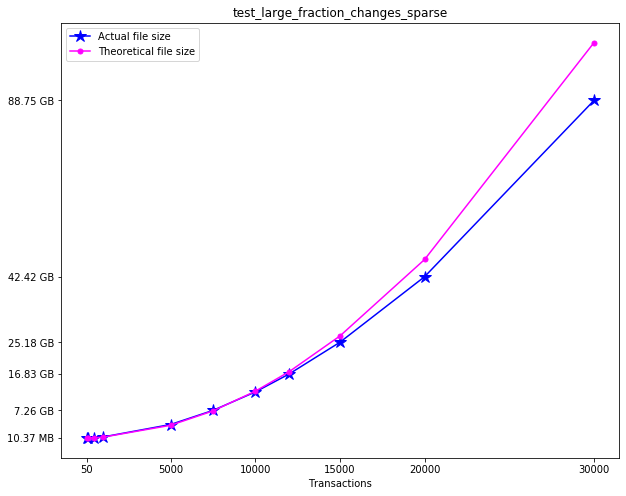

In [17]:
fig_large_fraction_changes = plt.figure(figsize=(10,8))
plt.plot(num_transactions_1, filesizes_1, '*-', ms=12, color='blue', label="Actual file size")
plt.plot(num_transactions_1, tsizes_1, 'o-', ms=5, color='magenta', label="Theoretical file size")
plt.xticks([50, 5000, 10000, 15000, 20000, 30000])
plt.xlabel("Transactions")
plt.title("test_large_fraction_changes_sparse")
plt.legend()
plt.yticks(filesizes_1[[0, 5, 7, 8, 9, 10]], sizelabels_1[[0, 5, 7, 8, 9, 10]])
plt.show()

Note that between 7500 transactions and 10000 transactions, there is a cross between the curves and the actual filesizes are **smaller** than the expected file size.

Changing the view to a logarithmic scale, we have this:

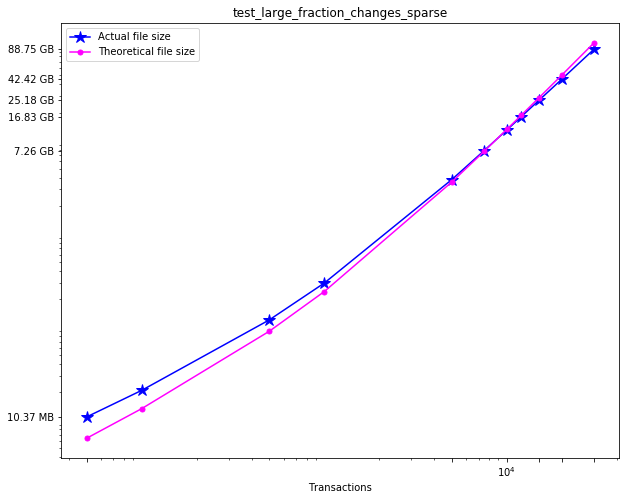

In [18]:
fig_large_fraction_changes_log = plt.figure(figsize=(10,8))
plt.loglog(num_transactions_1, filesizes_1, '*-', ms=12, color='blue', label="Actual file size")
plt.loglog(num_transactions_1, tsizes_1, 'o-', ms=5, color='magenta', label="Theoretical file size")
plt.xticks([50, 5000, 10000, 15000, 20000, 30000])
plt.xlabel("Transactions")
plt.title("test_large_fraction_changes_sparse")
plt.legend()
plt.yticks(filesizes_1[[0, 5, 7, 8, 9, 10]], sizelabels_1[[0, 5, 7, 8, 9, 10]])
plt.show()

### Finishing up

In [19]:
for test in tests:
    test['h5pyfile'].close()

# Test 2: Mostly appends (sparse) - outdated

In [ ]:
testname = "test_mostly_appends_sparse"

For this case, we are using the following number of transactions:

In [ ]:
num_transactions_2 = [50, 100, 500, 1000, 2000, 5000, 10000]

In [ ]:
# Setting up dictionary with test info
tests = []
for t in num_transactions_2:
    filename = os.path.join(path, testname+"_"+str(t)+".h5")
    h5pyfile = h5py.File(os.path.join(path, testname+"_"+str(t)+".h5"), 'r')
    data = VersionedHDF5File(h5pyfile)
    tests.append(dict(num_transactions=t, filename=filename, h5pyfile=h5pyfile, data=data))


    
# Computing file sizes
for test in tests:
    test['size'] = os.path.getsize(test['filename'])
    test['size_label'] = format_size(test['size'])
    print(f"File with {test['num_transactions']} versions has size {test['size_label']}")

In [ ]:
print("Array sizes:")
for test in tests:
    lengths = []
    for vname in test['data']._versions:
        if vname != '__first_version__':
            version = test['data'][vname]
            group_key = list(version.keys())[0]
            lengths.append(len(version[group_key]['val']))
    print(f"File with {test['num_transactions']}: min = {min(lengths)}, max = {max(lengths)}")

```
Array sizes:
File with 50: min = 1000, max = 50933
File with 100: min = 1000, max = 100857
File with 500: min = 1000, max = 500951
File with 1000: min = 1000, max = 1000660
File with 2000: min = 1000, max = 2000840
File with 5000: min = 1000, max = 5001604
File with 10000: min = 1000, max = 10000126
```

In [ ]:
test_mostly_appends_sparse = []
for test in tests:
    test_mostly_appends_sparse.append(dict((k, test[k]) for k in ['num_transactions', 'filename', 'size', 'size_label']))

In [ ]:
with open("test_mostly_appends_sparse_versions.pickle","wb") as pickle_out:
    pickle.dump(test_mostly_appends_sparse, pickle_out)

In [ ]:
with open("test_mostly_appends_sparse_versions.pickle", "rb") as pickle_in:
    test_mostly_appends_sparse = pickle.load(pickle_in)

In [ ]:
filesizes_2 = np.array([test['size'] for test in test_mostly_appends_sparse])
sizelabels_2 = np.array([test['size_label'] for test in test_mostly_appends_sparse])

In [ ]:
fig_mostly_appends_sparse = plt.figure(figsize=(10, 8))
#plt.loglog(num_transactions_2, filesizes_2, 'b')
plt.plot(num_transactions_2, filesizes_2, 'b')
plt.plot(num_transactions_2, filesizes_2, 'b*', ms=12)
plt.xticks([50, 2000, 5000, 10000])
plt.xlabel("Transactions")
plt.title("test_mostly_appends_sparse")
plt.yticks(filesizes_2[[0, 4, 5, 6]], sizelabels_2[[0, 4, 5, 6]])
plt.show()

## Test 2: Mostly Appends (Sparse)

![Test 2: Mostly Appends (Sparse)](test_mostly_appends_sparse_versions.png)

In [ ]:
for test in tests:
    test['h5pyfile'].close()

# Test 3: Small fraction changes sparse - outdated

In [ ]:
testname = "test_small_fraction_changes_sparse"

We have tested the following numbers of versions (or transactions):

In [ ]:
num_transactions_3 = [50, 100, 500, 1000, 5000, 7500, 10000, 12000, 15000, 20000, 30000]

In [ ]:
# Setting up dictionary with test info:
tests = []
for t in num_transactions_3:
    filename = os.path.join(path, testname+"_"+str(t)+".h5")
    h5pyfile = h5py.File(filename, 'r')
    data = VersionedHDF5File(h5pyfile)
    tests.append(dict(num_transactions=t, filename=filename, h5pyfile=h5pyfile, data=data))
    
# Computing file sizes
for test in tests:
    test['size'] = os.path.getsize(test['filename'])
    test['size_label'] = format_size(test['size'])

In [ ]:
for test in tests:
    lengths = []
    total_size = 0
    for vname in test['data']._versions:
        if vname != '__first_version__':
            version = test['data'][vname]
            group_key = list(version.keys())[0]
            lengths.append(len(version[group_key]['val']))
            total_size += len(version[group_key]['val'])
    test['theoretical_sizes'] = 24*total_size
    print(f"Maximum array size for file with {test['num_transactions']}: {max(lengths)}")

```
Array sizes:
File with 50: min = 5000, max = 5451
File with 100: min = 5000, max = 5996
File with 500: min = 5000, max = 10081
File with 1000: min = 5000, max = 15504
File with 2000: min = 5000, max = 25330
File with 5000: min = 5000, max = 57366
File with 10000: min = 5000, max = 109691
File with 20000: min = 5000, max = 212026
```

In [ ]:
test_small_fraction_changes_sparse = []
for test in tests:
    test_small_fraction_changes_sparse.append(dict((k, test[k]) for k in ['num_transactions', 'filename', 'size', 'size_label', 'theoretical_sizes']))

In [ ]:
with open("test_small_fraction_changes_sparse_versions.pickle","wb") as pickle_out:
    pickle.dump(test_small_fraction_changes_sparse, pickle_out)

In [ ]:
with open("test_small_fraction_changes_sparse_versions.pickle", "rb") as pickle_in:
    test_small_fraction_changes_sparse = pickle.load(pickle_in)

In [ ]:
filesizes_3 = np.array([test['size'] for test in test_small_fraction_changes_sparse])
sizelabels_3 = np.array([test['size_label'] for test in test_small_fraction_changes_sparse])
tsizes_3 = np.array([test['theoretical_sizes'] for test in test_large_fraction_changes_sparse])

In [ ]:
fig_small_fraction_changes = plt.figure(figsize=(10,8))
plt.plot(num_transactions_3, filesizes_3, '*-', ms=12, color='blue', label="Actual file size")
plt.plot(num_transactions_3, tsizes_3, 'o-', ms=5, color='magenta', label="Theoretical file size")
plt.xticks([50, 5000, 10000, 15000, 20000, 30000])
plt.xlabel("Transactions")
plt.title("test_small_fraction_changes_sparse")
plt.legend()
plt.yticks(filesizes_1[[0, 5, 7, 8, 9, 10]], sizelabels_1[[0, 5, 7, 8, 9, 10]])
plt.show()

## Test 3: Small Fraction Changes (Sparse)

![Test 3: Small Fraction Changes (Sparse)](test_small_fraction_changes_sparse_versions.png)

In [ ]:
for test in tests:
    test['h5pyfile'].close()

# Test 4: Mostly appends (dense) - outdated

In [ ]:
testname = "test_mostly_appends_dense"

We have tested the following number of versions (or transactions):

In [ ]:
num_transactions_4 = [50, 100, 500, 1000, 2000, 5000, 10000]

In [ ]:
tests = []
for t in num_transactions_4:
    filename = os.path.join(path, testname+"_"+str(t)+".h5")
    h5pyfile = h5py.File(os.path.join(path, testname+"_"+str(t)+".h5"), 'r')
    data = VersionedHDF5File(h5pyfile)
    tests.append(dict(num_transactions=t, filename=filename, h5pyfile=h5pyfile, data=data))
    
for test in tests:
    test['size'] = os.path.getsize(test['filename'])
    test['size_label'] = format_size(test['size'])
    print(f"File with {test['num_transactions']} versions has size {test['size_label']}")

In [ ]:
print("Array sizes:")
for test in tests:
    lengths = []
    for vname in test['data']._versions:
        if vname != '__first_version__':
            version = test['data'][vname]
            group_key = list(version.keys())[0]
            lengths.append(len(version[group_key]['val']))
    print(f"File with {test['num_transactions']}: min = {min(lengths)}, max = {max(lengths)}")

```
Array sizes:
File with 50: min = 900, max = 2760
File with 100: min = 900, max = 6720
File with 500: min = 900, max = 91945
File with 1000: min = 900, max = 425220
File with 2000: min = 900, max = 1615510
File with 5000: min = 900, max = 9819999
File with 10000: min = 900, max = 39638808
```

In [ ]:
test_mostly_appends_dense = []
for test in tests:
    test_mostly_appends_dense.append(dict((k, test[k]) for k in ['num_transactions', 'filename', 'size', 'size_label']))

In [ ]:
with open("test_mostly_appends_dense_versions.pickle","wb") as pickle_out:
    pickle.dump(test_mostly_appends_dense, pickle_out)

In [ ]:
with open("test_mostly_appends_dense_versions.pickle", "rb") as pickle_in:
    test_mostly_appends_dense = pickle.load(pickle_in)

In [ ]:
filesizes_4 = np.array([test['size'] for test in test_mostly_appends_dense])
sizelabels_4 = np.array([test['size_label'] for test in test_mostly_appends_dense])

In [ ]:
fig_mostly_appends_dense = plt.figure(figsize=(10,8))
#plt.loglog(num_transactions_4, filesizes_4, 'b')
plt.plot(num_transactions_4, filesizes_4, 'b')
plt.plot(num_transactions_4, filesizes_4, 'b*', ms=12)
plt.xticks([50, 2000, 5000, 10000])
plt.xlabel("Transactions")
plt.title("test_mostly_appends_dense")
plt.yticks(filesizes_4[[0, 5, 6]], sizelabels_4[[0, 5, 6]])
plt.show()

## Test 4: Mostly Appends (Dense)

![Test 4: Mostly Appends (Dense)](test_mostly_appends_dense_versions.png)

### Finishing up

In [ ]:
for test in tests:
    test['h5pyfile'].close()

# Full comparison

In [ ]:
fig_all = plt.figure(figsize=(14, 12))
plt.plot(num_transactions_1[:-1], filesizes_1[:-1], 'r', label = "large_fraction", lw=5)
plt.plot(num_transactions_2, filesizes_2, 'b', label = "mostly_appends_sparse", lw=5)
plt.plot(num_transactions_3[:-1], filesizes_3[:-1], 'm', label = "small_fraction", lw=5)
plt.plot(num_transactions_4, filesizes_4, 'g', label = "mostly_appends_dense", lw=5)
plt.legend()

## Understanding each file

Each versioned HDF5 file contains 3 datasets per version:
- `key0`, an array of `int64`
- `key1`, an array of `int64`
- `val`, an array of `float64`
plus metadata about groups, datasets and versions.

This means that each file has  

```
nversions * 24 * arraysize + metadata
```
bytes of information.